# Geo-Spatial Analysis of Overcrowding Busses in Metro Vancouver
By Francis Lee

**Outcomes**

- Use regression and visualization methods learned in ECON 323 to conduct a geospatial analysis of Translink and overcrowding busses

## Introduction

TransLink is Metro Vancouver's transportation network. As an essential public service, Translink conducts surveys every year to measure their progress towards their Customer Experience Action Plan in which they say they aim to increase accessibility, cleanliness, and comfort. With the COVID-19 pandemic, it's become abundtantly clear that an overcrowded bus can heavily affect all three of those factors. This project aims to show the areas in Metro Vancouver that are experiencing the most amount of boardings and overcrowding. As well as asking, is overcrowding just an issue of how many people are using each line? Or are busses not being equally distributed for each bus line?


This project can also be found on https://github.com/farnyp/econ323proj

## Data Sourcing and Methodology

All data sources collected for this project are provided publically by Translink. I will be using 3 datasets, 2 of which are provided by the 2019 TransLink Service Performance Review: *Bus: Annual Indicators by Route and Year*, *Bus: Key Characteristics by Route*, *TransLink Transit GIS Data, 09 August 2019*.

This project will disregard all other major transportation routes such as SkyTrain, West Coast Express, and SeaBus and focus only on bus routes around the Metro Vancouver area. I will be performing two regression analyses, using a rudimentary linear regression model and a neural network. Afterwards, we will focus on visualizing the geospatial data of bus routes.

In [1]:
import folium
from folium import plugins
from folium.plugins import HeatMap
import geojson
import geopandas as gpd
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import qeds
qeds.themes.mpl_style();
import requests
import shapefile
from sklearn import (
    linear_model, metrics, neural_network, preprocessing, pipeline, model_selection
)
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [2]:
#load first dataset
df = pd.read_csv('https://www.translink.ca/-/media/translink/documents/plans-and-projects/managing-the-transit-network/tspr/csv-data/tspr2019_bus-annual-indicators-by-route-and-year.csv')
df.head()

,Year,line_no,Annual_APC_Boardings,AVG_Daily_APC_Boardings_MF,AVG_Daily_APC_Boardings_Sat,AVG_Daily_APC_Boardings_SunHol,Annual_Revenue_Hours,Annual_Service_Hours,Average_APC_Boarding_Per_Revenue_Hour,Average_Passenger_Turnover,Perc_Trips_w_Overcrowding,Average_Passenger_Load_Bi_Directional,Average_Peak_Load_Factor,Average_Capacity_Utilization,Percentage_of_Revenue_Hours_with_Overcrowding,Annual_Revenue_Hours_with_Overcrowding,On_Time_Performance_Percentage,Bus_Bunching_Percentage,AVG_speed_km_per_hr
0,2015,2,1331644.617,4216.373363,2803.377373,2127.033284,22722.45000,26081.91667,58.604799,60.008729,0.552399,19.912918,39.825836,NaN,0.642079,145.878129,74.850573,3.267047,15.188295
1,2016,2,2815232.708,8771.913671,6155.099423,4740.367005,43447.66667,46477.30000,64.795947,83.694318,4.328673,25.360682,50.621571,26.936991,4.928824,2141.448595,77.549258,5.908017,16.618055
2,2017,2,4251079.674,13251.289930,9412.374967,7374.551678,62814.33333,66424.18333,67.676905,81.111108,3.894340,25.688522,51.308164,27.389038,4.438614,2788.076999,72.274889,8.348760,17.170330
3,2018,2,4785396.625,15073.237110,10246.844570,7796.881885,63128.48333,66813.18333,75.804080,90.842739,4.988970,26.263301,52.445513,26.644564,5.847321,3691.311806,79.710269,6.739947,17.095551
4,2019,2,5020267.619,15775.483880,10699.814920,8427.828399,64671.03333,68715.28333,77.627763,95.865574,7.620995,30.017868,59.956031,29.739349,8.541584,5523.876312,80.867753,5.865662,16.741806


The dataset contains a large number of variables, most of which I will not be using for the purpose of this project. Therefore, I will only be keeping a few quantitative variables such as the annual passenger boardings, average weekday boardings, and percentage of trips that were overcrowded.

In [3]:
#remove unwanted variables
subset = df.loc[:,['line_no', 'Annual_APC_Boardings', 'AVG_Daily_APC_Boardings_MF', 'Perc_Trips_w_Overcrowding']]
subset

,line_no,Annual_APC_Boardings,AVG_Daily_APC_Boardings_MF,Perc_Trips_w_Overcrowding
0,2,1.331645e+06,4216.373363,0.552399
1,2,2.815233e+06,8771.913671,4.328673
2,2,4.251080e+06,13251.289930,3.894340
3,2,4.785397e+06,15073.237110,4.988970
4,2,5.020268e+06,15775.483880,7.620995
...,...,...,...,...
1075,N9,6.809832e+04,184.628490,0.139470
1076,N9,6.635767e+04,163.943514,0.557880
1077,N9,9.147289e+04,205.059275,1.557286
1078,N9,1.102660e+05,246.006877,0.501393


To properly use this dataset, I will need to fill all Null values with 0 as having no value in these variables means that there were no boardings.

In [4]:
#check for null values in the dataset and clean them
print(subset.isnull().sum())
clean_subset = subset.fillna(0)
print(clean_subset.isnull().sum())

line_no                        0
Annual_APC_Boardings          38
AVG_Daily_APC_Boardings_MF    53
Perc_Trips_w_Overcrowding     48
dtype: int64
line_no                       0
Annual_APC_Boardings          0
AVG_Daily_APC_Boardings_MF    0
Perc_Trips_w_Overcrowding     0
dtype: int64


My next step is to load the second variable which includes the names and subregion for each line. Then, when I merge the two datasets together, I will have a very tidy and descriptive dataset that is very pleasing and easy to read.

In [5]:
#read second dataset, including characteristics for each line
names = pd.read_csv('./tspr2019_bus-key-characteristics-by-route (1).csv')
names = names.sort_values(by = 'Line')
names = names.loc[:,['Line', 'LineName', 'Sub-Region of Primary Service']]
names.head()

,Line,LineName,Sub-Region of Primary Service
3,005/006,ROBSON–DAVIE/DOWNTOWN,Vancouver/UBC
9,015/050,CAMBIE/OLYMPIC VLG STN – WATERFRONT STN/FALSE ...,Vancouver/UBC
28,068/070,UBC EXCH/WEST MALL– WESBROOK MALL,Vancouver/UBC
7,10,GRANVILLE/DOWNTOWN,Vancouver/UBC
33,100,22ND ST STN/MARPOLE,Vancouver/UBC


In [6]:
#merge grouped_subset and names df and then remove unwanted variables
merged_df = pd.merge(clean_subset, names, left_on = 'line_no', right_on = 'Line')
clean_df = merged_df.loc[:,['Line', 'LineName', 'Sub-Region of Primary Service',
                            'Annual_APC_Boardings', 'AVG_Daily_APC_Boardings_MF', 
                            'Perc_Trips_w_Overcrowding']]
clean_df.head()

,Line,LineName,Sub-Region of Primary Service,Annual_APC_Boardings,AVG_Daily_APC_Boardings_MF,Perc_Trips_w_Overcrowding
0,2,MACDONALD/DOWNTOWN,Vancouver/UBC,1331644.617,4216.373363,0.552399
1,2,MACDONALD/DOWNTOWN,Vancouver/UBC,2815232.708,8771.913671,4.328673
2,2,MACDONALD/DOWNTOWN,Vancouver/UBC,4251079.674,13251.289930,3.894340
3,2,MACDONALD/DOWNTOWN,Vancouver/UBC,4785396.625,15073.237110,4.988970
4,2,MACDONALD/DOWNTOWN,Vancouver/UBC,5020267.619,15775.483880,7.620995


This dataset brings a tear to my eye

## Regression Analysis

For these next steps, I will be performing a linear regression and a neural network regression. I will be focusing my regression analysis on average weekday boardings vs percentage of trips with overcrowding.

In [7]:
#using a simple linear regression model

#drop unwanted variables so only two remain
X_data = clean_df.drop(['Line', 'LineName', 'Sub-Region of Primary Service',
                            'Annual_APC_Boardings'], axis=1).copy()


#change the datatype in each columns to float
for col in list(X_data):
    X_data[col] = X_data[col].astype(float)
y_val = clean_df['Perc_Trips_w_Overcrowding']

#creating the model instance
lr_model = linear_model.LinearRegression()

# fit the model
lr_model.fit(X_data[['AVG_Daily_APC_Boardings_MF']], y_val)

# return the coefficients
beta_0 = lr_model.intercept_
beta_1 = lr_model.coef_[0]

print(f"Model: Percentage of Overcrowding = {beta_0:.4f} + {beta_1:.4f} average weekday boardings")

Model: Percentage of Overcrowding = 1.7656 + 0.0004 average weekday boardings


A humourous takeaway that can be seen from this result is that with average weekday boardings being 0, you will still experience a percentage of overcrowded trips of 1.8%. In seriousness, we can infer that these two variables may not be heavily correlated with each other. We can visualize this with a scatterplot below.

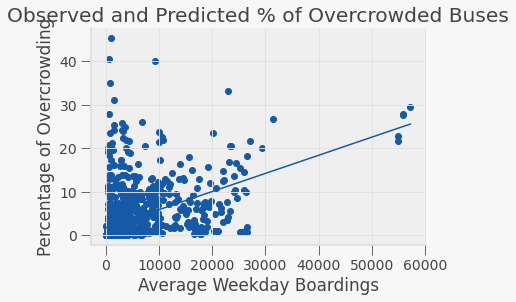

In [8]:
#visualize linear regression best fit line
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = [16,9]
colors = qeds.themes.COLOR_CYCLE
ax.scatter(X_data["AVG_Daily_APC_Boardings_MF"],y_val, color=colors[0],label='observed')
ax.set_title("Observed and Predicted % of Overcrowded Buses")
ax.set_ylabel("Percentage of Overcrowding")
ax.set_xlabel("Average Weekday Boardings")
x = np.array([0, X_data["AVG_Daily_APC_Boardings_MF"].max()])
ax.plot(x, beta_0 + beta_1*x)

As we can see from this scatterplot, these two variables are not heavily correlated. Next, we will move on to regression using neural networks.

In [9]:
#regression analysis using neural networks to see if avg daily boardings correlate with percentage of busses that are overcrowded

#split the data into training and testing sets using the observed data
X_train, X_test,y_train,y_test=train_test_split(X_data,y_val,test_size=0.3,random_state=101)

# scale the model using two hidden layers N = 50 and N = 30
nn_scaled_model = pipeline.make_pipeline(
    preprocessing.StandardScaler(),  
    neural_network.MLPRegressor((50, 30))  
)

#fit the data
nn_scaled_model.fit(X_train,y_train)

#return the MSE for both training and testing sets
mse_train=metrics.mean_squared_error(y_train, nn_scaled_model.predict(X_train))
mse_test=metrics.mean_squared_error(y_test, nn_scaled_model.predict(X_test))

print(f"Scaled mse of training set {mse_train}")
print(f"Scaled mse of testing set {mse_test}")

Scaled mse of training set 0.00440701424411655
Scaled mse of testing set 0.005768473194148525


Using a scaled neural network model, we can see that the MSE is very low, meaning the model is a strong predictor. We can visualize the predicted values below.

Text(0.5, 0, 'Average Weekday Boardings')

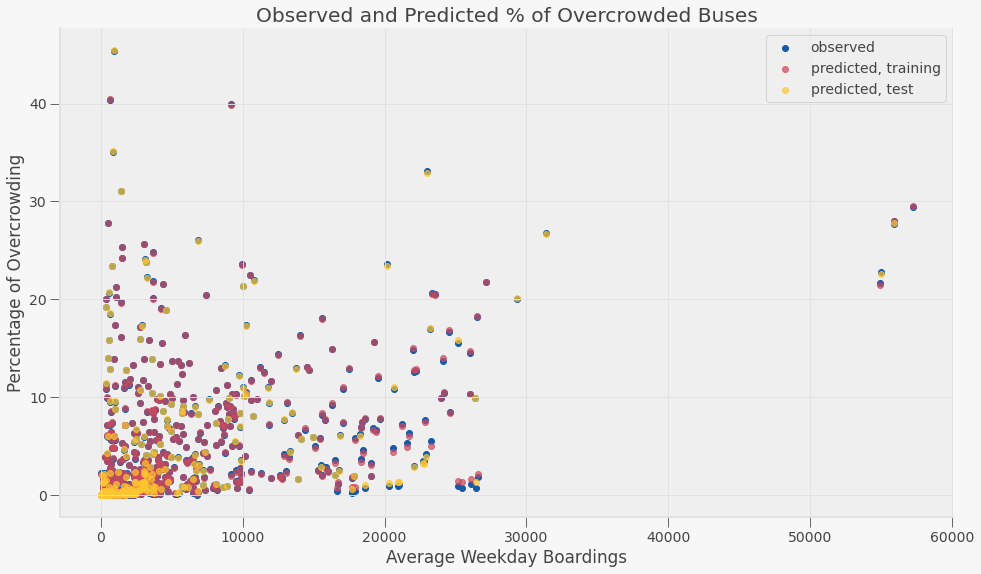

In [12]:
#visualizing the data
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = [16,9]
colors = qeds.themes.COLOR_CYCLE
ax.scatter(X_data["AVG_Daily_APC_Boardings_MF"],y_val, color=colors[0],label='observed')
ax.scatter(X_train["AVG_Daily_APC_Boardings_MF"],nn_scaled_model.predict(X_train), color=colors[1],alpha=0.7,label='predicted, training')
ax.scatter(X_test["AVG_Daily_APC_Boardings_MF"],nn_scaled_model.predict(X_test), color=colors[2], alpha=0.7, label='predicted, test')
ax.legend()
ax.set_title("Observed and Predicted % of Overcrowded Buses")
ax.set_ylabel("Percentage of Overcrowding")
ax.set_xlabel("Average Weekday Boardings")

## Geospatial Analysis: Heatmapping the average weekday boardings and percentage of trips with overcrowding
This next section will focus on using geospatial data to visualize the difference in the two variables. Through this analysis, we can see which regions have the highest passengers and overcrowding, and if those areas are relatively the same.

We will start by grouping the dataframe by year. In the code, I am grouping by line_no as I have removed the Year variable, but each row containing the same line_no contains observations for each year from 2015 to 2019. Thus, grouping by line_no will have the same effect.

In [14]:
#Group the subset by line (year) to get the mean of the past 5 years (2015 - 2019)
grouped_subset = clean_df.groupby(['Line','Sub-Region of Primary Service'],as_index=False).mean()
grouped_subset

,Line,Sub-Region of Primary Service,Annual_APC_Boardings,AVG_Daily_APC_Boardings_MF,Perc_Trips_w_Overcrowding
0,005/006,Vancouver/UBC,6.374795e+06,18830.398758,4.236390
1,015/050,Vancouver/UBC,2.656625e+06,7882.677371,0.894783
2,068/070,Vancouver/UBC,3.263454e+05,935.398170,0.505417
3,10,Vancouver/UBC,4.532765e+06,14698.296742,2.324470
4,100,Vancouver/UBC,3.982613e+06,12283.349100,11.053090
...,...,...,...,...,...
211,N22,Vancouver/UBC,1.886693e+04,47.494924,0.031746
212,N24,North Shore,7.211895e+04,155.982721,0.802207
213,N35,Burnaby/New Westminster,8.389376e+04,219.032682,0.712822
214,N8,Vancouver/UBC,5.866994e+04,164.393658,0.885412


As a bonus, and to help show how the comparative mean differences in each variable as well as the number of lines in each sub-region, we will group the data by Sub-Region of Primary Service.

In [15]:
#visualize how many lines are in each subregion and the mean statistics for each variable
count_lines = grouped_subset.groupby('Sub-Region of Primary Service').agg({'Line':'count', 
                         'Annual_APC_Boardings': 'mean', 'AVG_Daily_APC_Boardings_MF': 'mean', 
                          'Perc_Trips_w_Overcrowding': 'mean'})
count_lines


,Line,Annual_APC_Boardings,AVG_Daily_APC_Boardings_MF,Perc_Trips_w_Overcrowding
Sub-Region of Primary Service,,,,
Burnaby/New Westminster,28,1.316261e+06,4327.883966,3.275518
Maple Ridge/Pitt Meadows,10,3.153137e+05,1038.471802,0.258993
North Shore,33,6.821122e+05,2122.847162,3.522722
Northeast Sector,25,4.352685e+05,1437.728079,0.756653
Southeast,52,8.780446e+05,2803.819688,4.811596
Southwest,30,7.141025e+05,2328.210006,2.376002
Vancouver/UBC,38,3.710184e+06,11545.243000,5.295305


What we can see from this is that while Vancouver/UBC has by far the highest number of average weekday boardings, it barely beats the Southeast region in Overcrowding with a 0.48% difference. Meanwhile, the Southeast region has nearly 9000 less passengers on average, as well as 14 more bus routes.

We begin our mapping by loading our third and final dataset.

In [16]:
#load third dataset
bus_routes = gpd.read_file('./Shapes_Trips_Routes_09Aug19.geojson')
bus_routes.head()

,shape_id,begin,end,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled,route_id,service_id,trip_id,...,bikes_allowed,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color,geometry
0,232619,1,56,49.272717,-123.164713,9,0.6310,6612.0,1.0,10611096.0,...,0.0,TL,2,Macdonald/Downtown,None,3.0,None,None,None,"LINESTRING (-123.16828 49.26838, -123.16825 49..."
1,232620,1,77,49.261378,-123.168265,9,0.7048,6612.0,3.0,10695798.0,...,0.0,TL,2,Macdonald/Downtown,None,3.0,None,None,None,"LINESTRING (-123.17228 49.25764, -123.17039 49..."
2,232621,1,125,49.276950,-123.132402,99,8.6467,6612.0,3.0,10695802.0,...,0.0,TL,2,Macdonald/Downtown,None,3.0,None,None,None,"LINESTRING (-123.18589 49.23455, -123.18588 49..."
3,232622,1,79,49.284409,-123.121097,9,0.7083,6612.0,3.0,10695813.0,...,0.0,TL,2,Macdonald/Downtown,None,3.0,None,None,None,"LINESTRING (-123.12199 49.28646, -123.12086 49..."
4,232623,1,128,49.248408,-123.170890,99,7.8309,6612.0,3.0,10695809.0,...,0.0,TL,2,Macdonald/Downtown,None,3.0,None,None,None,"LINESTRING (-123.12199 49.28646, -123.12086 49..."


Next we will create the data series required for the two heatmaps

In [17]:
#create a subset containing our two required variables
two_variable_subset = grouped_subset.loc[:,['Line','AVG_Daily_APC_Boardings_MF', 'Perc_Trips_w_Overcrowding']]

#merge datasets using a many to one key
mapping_data = pd.merge(bus_routes, two_variable_subset, left_on="route_short_name", right_on="Line", how="left", validate="m:1")

#remove any rows in which the two variables are null
mapping_data = mapping_data[pd.notnull(mapping_data['AVG_Daily_APC_Boardings_MF'])]
mapping_data = mapping_data[pd.notnull(mapping_data['Perc_Trips_w_Overcrowding'])]

#create a heatmap dataset for average weekday boardings
max_amount = float(mapping_data['AVG_Daily_APC_Boardings_MF'].max())
weekday_heat_data = HeatMap( list(zip(mapping_data.shape_pt_lat.values, mapping_data.shape_pt_lon.values, mapping_data.AVG_Daily_APC_Boardings_MF.values)),
                   min_opacity=0.1,
                   max_val=max_amount,
                   radius=12, blur=10, 
                   max_zoom=1, 
                 )

#create a heatmap dataset for percentage of trips with overcrowding
max_amount = float(mapping_data['Perc_Trips_w_Overcrowding'].max())
overcrowding_heat_data = HeatMap( list(zip(mapping_data.shape_pt_lat.values, mapping_data.shape_pt_lon.values, mapping_data.Perc_Trips_w_Overcrowding.values)),
                   min_opacity=0.1,
                   max_val=max_amount,
                   radius=12, blur=10, 
                   max_zoom=1, 
                 )



Finally, we create the basemap as well as the first map where we show all the transit routes in Metro Vancouver

In [22]:
#create a function to create folium basemap
def basemap(l = [49.2, -122.95], z = 11):
    base = folium.Map(location = l, control_scale = True, tiles = 'OpenStreetMap', zoom_start = z)
    return base

#create the map of transit routes
route_map = basemap()
folium.GeoJson(mapping_data).add_to(route_map)
route_map

Next, we will see visualize how the regions differ in term of average weekday boardings.

In [19]:
#create heat map of average weekday boardings
heat_map_1 = basemap()
heat_map_1.add_child(weekday_heat_data)

Finally, we will visualize the intensity of trips with overcrowding with another heat map.

In [20]:
#create trips with overcrowding heat map
heat_map_2 = basemap()
heat_map_2.add_child(overcrowding_heat_data)

Through the visualizations above, we can see that overcrowding is much more varied, with the North Shore and Southeast regions having much more hotspots than in the map of average weekday boardings.

## Conclusion

Based on the regression analysis and geospatial analysis, we can see that TransLink does not use Average Weekday Passenger Boardings as a strong indicator for dealing with overcrowding in busses. Interestingly, Vancouver sees less overcrowding compared to average boardings, while the regions surrounding Vancouver see quite the opposite. Despite the limitations, this project helps me recommend that TransLink use more infrastructure and busses in the regions surrounding Vancouver.

#### Bonus: Save the maps in .html
You can run the code below to save all the maps in .html format.

In [23]:
route_map.save('transit_routes.html')
heat_map_1.save('avg_weekday.html')
heat_map_2.save('overcrowding.html')